## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import pickle
import cv2
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
%matplotlib inline

## Camera Calibration Matrix and Distortion Coefficient Calculations for a set of ChessBoard Images 

In [2]:
nx = 9
ny = 6

objpoints = [] # 3-D points in Object Sapce
imgpoints = [] # 2-D points in Image Plane

images = glob.glob('camera_cal/calibration*.jpg')

print(images)

directory ='Undistorted_Images_Dir'
if not os.path.exists(directory):
    os.makedirs(directory)

['camera_cal\\calibration1.jpg', 'camera_cal\\calibration10.jpg', 'camera_cal\\calibration11.jpg', 'camera_cal\\calibration12.jpg', 'camera_cal\\calibration13.jpg', 'camera_cal\\calibration14.jpg', 'camera_cal\\calibration15.jpg', 'camera_cal\\calibration16.jpg', 'camera_cal\\calibration17.jpg', 'camera_cal\\calibration18.jpg', 'camera_cal\\calibration19.jpg', 'camera_cal\\calibration2.jpg', 'camera_cal\\calibration20.jpg', 'camera_cal\\calibration3.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg', 'camera_cal\\calibration6.jpg', 'camera_cal\\calibration7.jpg', 'camera_cal\\calibration8.jpg', 'camera_cal\\calibration9.jpg']


In [3]:

def Calc_CamCalibMatrix(nx,ny,img,objpoints,imgpoints):
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    #Finding in mtx, dst
    #img = cv2.imread(filename)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs


## Distortion Correction on Raw Images (Undistort Images)

In [4]:
def Undistort_Images(Image,CalibMatrix,Dist_Coeff):
    return cv2.undistort(Image,CalibMatrix,Dist_Coeff,None,CalibMatrix)
    

## Distortion Correction Result on Single Image

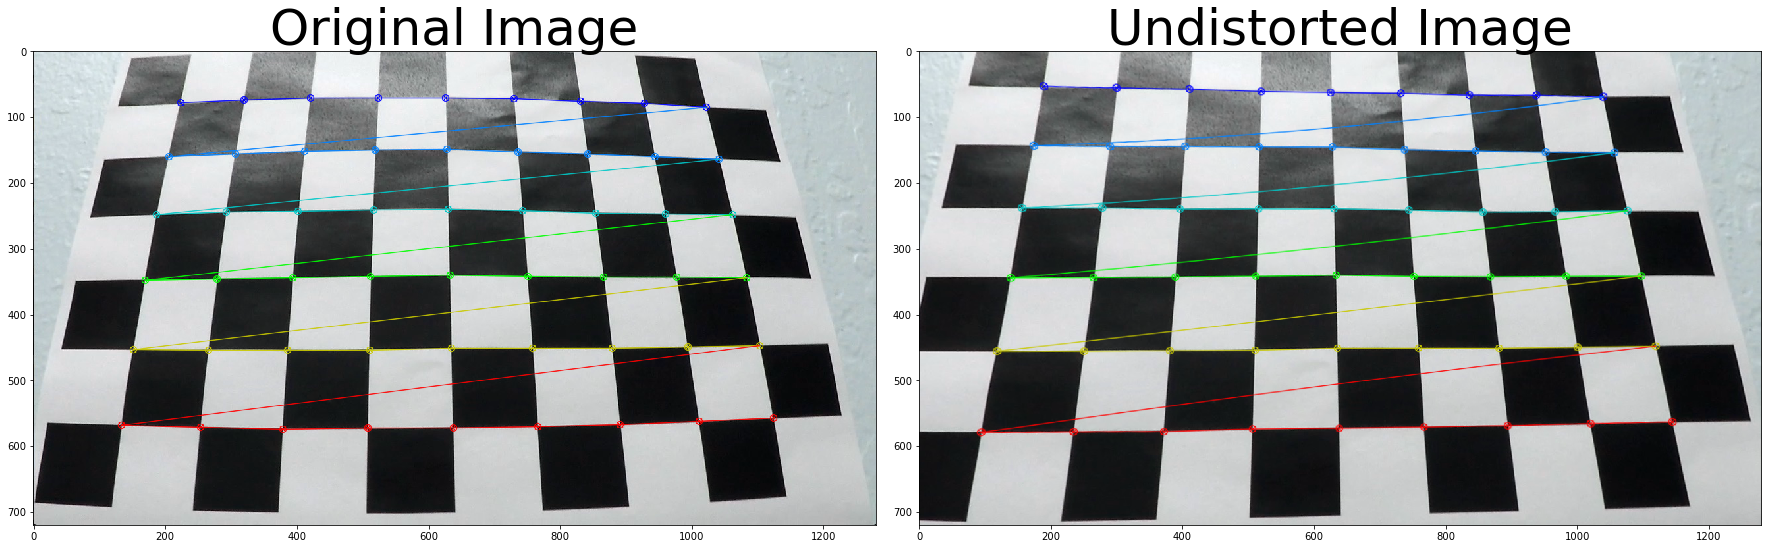

In [6]:
nx = 9
ny = 6

objpoints = [] # 3-D points in Object Sapce
imgpoints = [] # 2-D points in Image Plane
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Finding in mtx, dst
img = cv2.imread('camera_cal/calibration3.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)

    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

undistorted = Undistort_Images(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Display Undistorted ChessBoard Images

In [17]:

def Disp_UnDistortedImages(images): 
    for filename in images:
        if(filename=='camera_cal\\calibration2.jpg' or filename=='test_images\\test1.jpg' or filename=='test_images\\straight_lines1.jpg'):
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ret, mtx, dist, rvecs, tvecs = Calc_CamCalibMatrix(nx,ny,img,objpoints,imgpoints)
            Undistorted_Image = Undistort_Images(img,mtx,dist)
            filenamesplit = filename.split("\\")
            Undistorted_Image_Save = cv2.cvtColor(Undistorted_Image, cv2.COLOR_BGR2RGB)
            cv2.imwrite(directory +'\\Undistorted_'+filenamesplit[1],Undistorted_Image_Save)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(Undistorted_Image)
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        

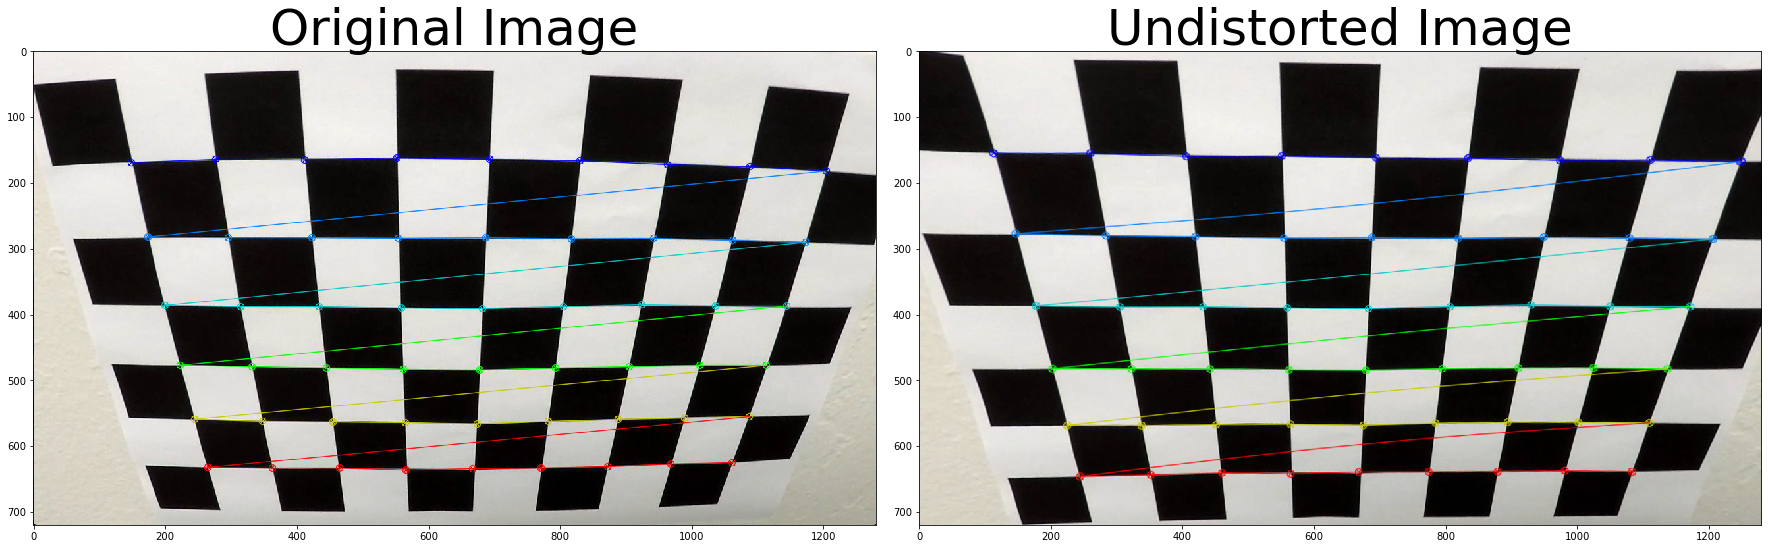

In [18]:
Disp_UnDistortedImages(images)

## Display Undistorted Test Images

In [19]:
testimages = glob.glob('test_images/test*.jpg')

print(testimages)

['test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']


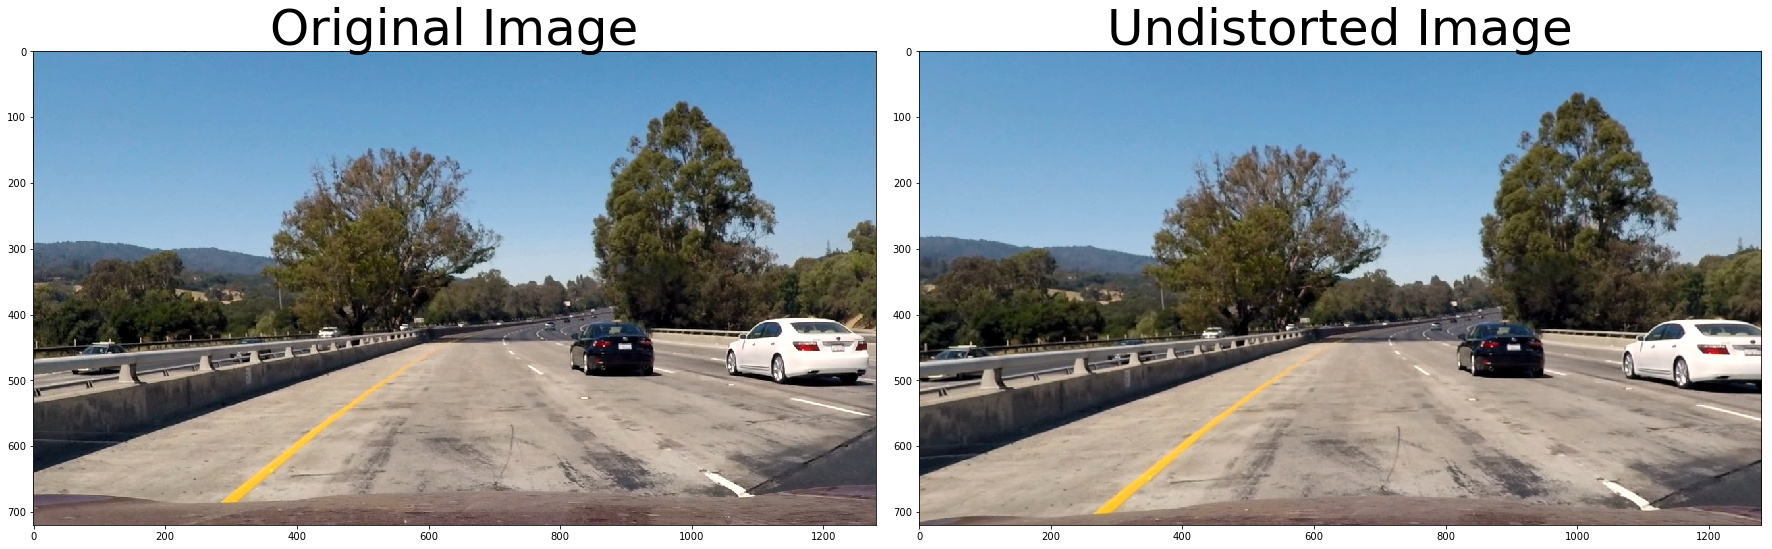

In [20]:
Disp_UnDistortedImages(testimages)

In [21]:
strline_images = glob.glob('test_images/straight_lines*.jpg')

print(strline_images)

['test_images\\straight_lines1.jpg', 'test_images\\straight_lines2.jpg']


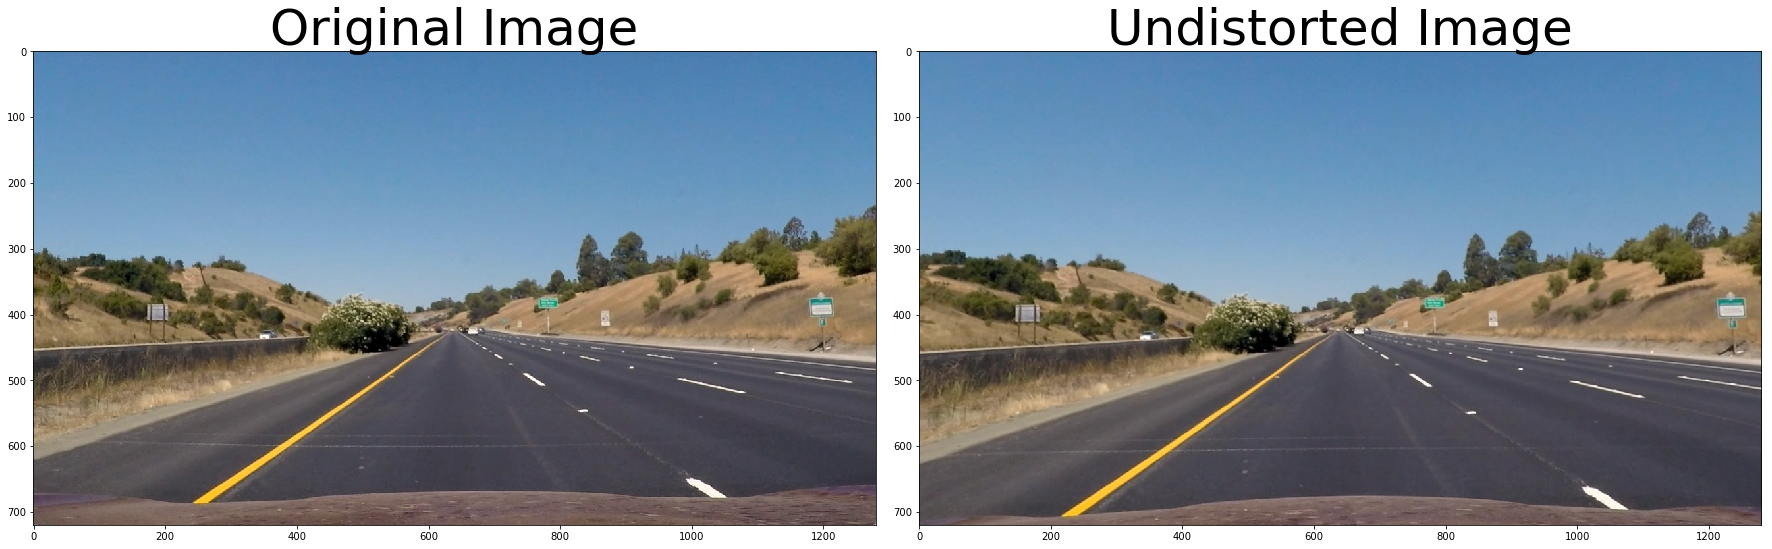

In [22]:
Disp_UnDistortedImages(strline_images)

## Create Threshold Binary Images

In [23]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled_sobel = None
    
    # Sobel x
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
    # Sobel y
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
        abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_magnitude = np.absolute(magnitude)
    scaled_magnitude = np.uint8(255*abs_magnitude/np.max(abs_magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    
    return dir_binary


def combined_s_gradient_thresholds(img,visulaize_perstranfrom_flag=False,show=False):

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    
    #filenamesplit = filename.split("\\")
    
    #directory = 'ComboThreshGrad_ImgList'
    #if not os.path.exists(directory):
        #os.makedirs(directory)
    #gray_binary = cv2.cvtColor(combined_binary, cv2.COLOR_RGB2GRAY)
    #cv2.imwrite(directory +'\\Combined_BinaryImages_'+filenamesplit[1],gray_binary)
    
    if show == True:
        if(visulaize_perstranfrom_flag==False):
            f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
            ax1.set_title('Actual Undistorted image')
            ax1.imshow(img)
            ax2.set_title('Combined gradx,grady,magnitude,direction')
            ax2.imshow(combined, cmap='gray')
            ax3.set_title('Color thresholding')
            ax3.imshow(s_binary, cmap='gray')
            ax4.set_title('Combined all')
            ax4.imshow(combined_binary, cmap='gray')
        
    return combined_binary


In [24]:
def Display_Threshold_Binary_Images(testimages):
    for filename in testimages:
        if(filename=='test_images\\test1.jpg'):
            img = cv2.imread(filename)
            ret, mtx, dist, rvecs, tvecs = Calc_CamCalibMatrix(nx,ny,img,objpoints,imgpoints)
            Undistorted_Image = Undistort_Images(img,mtx,dist)
            #combined_binary_image = combined_s_gradient_thresholds(img,filename,False, True)
            combined_binary_image = combined_s_gradient_thresholds(Undistorted_Image,False, True)
    

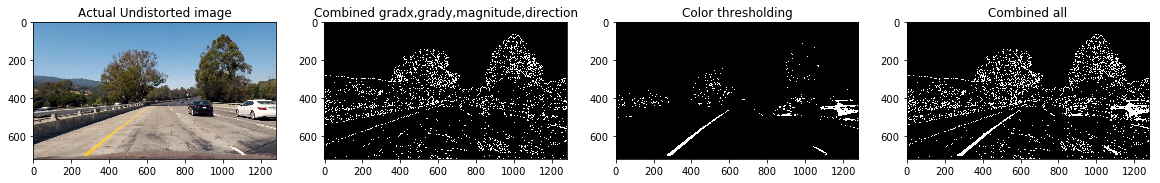

In [25]:
Display_Threshold_Binary_Images(testimages)

## Perspective Transform step

In [26]:
# Perspective Transform Function
def Perpective_Transform_Image(combined_binary_image, nx, ny): 
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (combined_binary_image.shape[1], combined_binary_image.shape[0])
    
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    PerspTrnsfrm_Matrix = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(combined_binary_image, PerspTrnsfrm_Matrix, img_size, flags=cv2.INTER_NEAREST)
    
    return warped, PerspTrnsfrm_Matrix

In [27]:
def Display_PerspecTransfrmed_Image(testimages,visulaize_perstranfrom_flag = True):
    #directory = 'Warped_Images'
    #if not os.path.exists(directory):
            #os.makedirs(directory)
    for filename in testimages:
        if(filename=='test_images\\test1.jpg'):
            img = cv2.imread(filename)
            ret, mtx, dist, rvecs, tvecs = Calc_CamCalibMatrix(nx,ny,img,objpoints,imgpoints)
            Undistorted_Image = Undistort_Images(img,mtx,dist)
            combined_binary_image = combined_s_gradient_thresholds(Undistorted_Image,visulaize_perstranfrom_flag, True)
            warped_img, PerspTrnsfrm_Matrix = Perpective_Transform_Image(combined_binary_image, nx, ny)    
            #gray_binary = cv2.cvtColor(combined_binary, cv2.COLOR_RGB2GRAY)
            #filenamesplit = filename.split('\\')
            #cv2.imwrite(directory +'\\WarpedImages_'+filenamesplit[1],warped_img)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(combined_binary_image, cmap='gray')
            ax1.set_title('Binary Threshold Image', fontsize=50)
            ax2.imshow(warped_img,cmap='gray')
            ax2.set_title('Warped Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

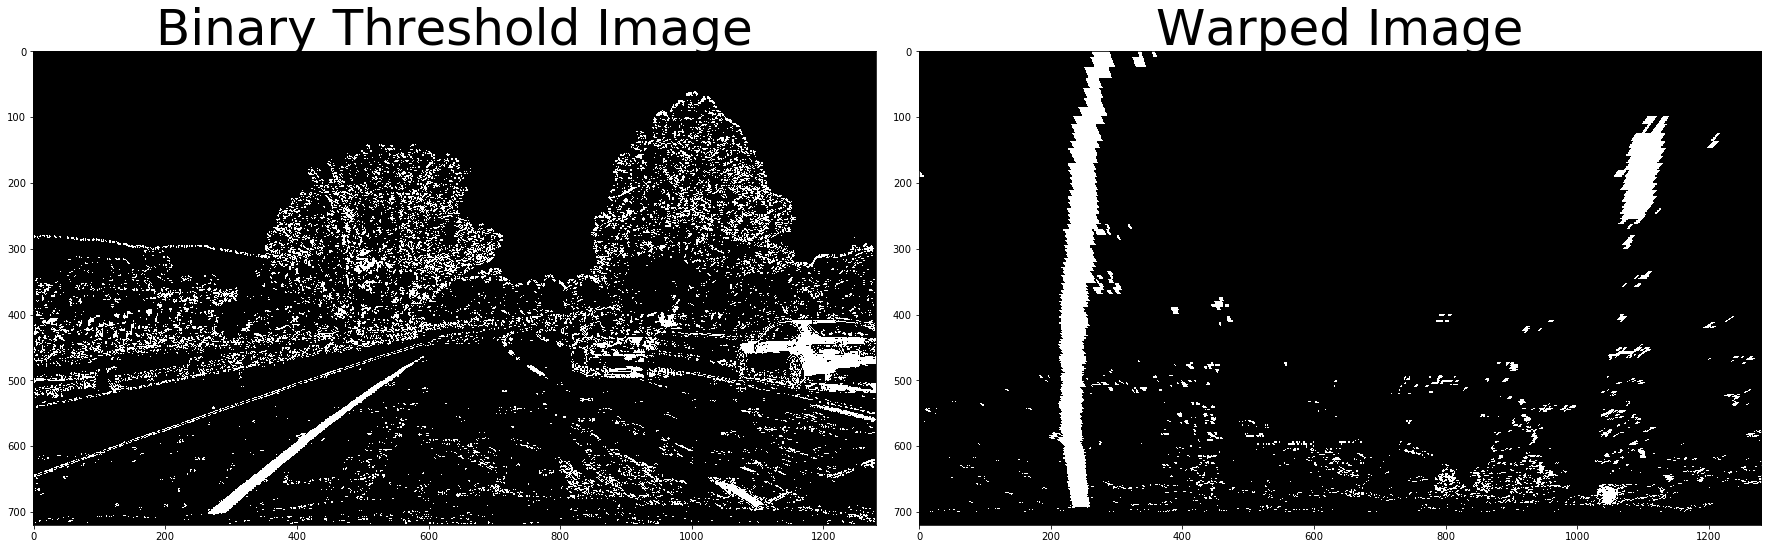

In [28]:
Display_PerspecTransfrmed_Image(testimages,True)

## Detecting Lane Lines 

In [29]:
def Detect_lines(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def Detect_lines_beyond(left_fit, right_fit, binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new

## Displaying Detected Lane Lines 

In [31]:
def Display_DetectedLanes(f, ax,testimages,visulaize_perstranfrom_flag = True,margin = 100):
    
    i=0
    j=0

    for filename in testimages:
        #if(filename=='test_images\\test1.jpg'):
        img = cv2.imread(filename)
        ret, mtx, dist, rvecs, tvecs = Calc_CamCalibMatrix(nx,ny,img,objpoints,imgpoints)
        Undistorted_Image = Undistort_Images(img,mtx,dist)
        combined_binary_image = combined_s_gradient_thresholds(Undistorted_Image,visulaize_perstranfrom_flag, True)
        warped_img, PerspTrnsfrm_Matrix = Perpective_Transform_Image(combined_binary_image, nx, ny) 
        left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = Detect_lines(warped_img) 
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                        ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                        ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        ax[i,j].set_title('Detected Lanes')
        
        # rseultreshaped = np.reshape(result,(result.shape[1],result.shape[0],result.shape[2]))

        ax[i,j].imshow(result) 
        
        #print(rseultreshaped.shape)
        
        #indexlist_leftlane =[]
        
        #indexlist_rightlane =[]
        
        #for k in range(len(left_fitx)):
            #col = k+1
            #indexlist_leftlane.append("A"+ str(col))
            #indexlist_rightlane.append("A"+ str(col))
            
        #left_fitx_series = pd.DataFrame(data=left_fitx, dtype='int',index=indexlist_leftlane,columns =['Coords'])
        
        #right_fitx_series =  pd.DataFrame(data=right_fitx, dtype='int',index=indexlist_rightlane,columns=['Coords'])
        
        #left_lane = left_fitx_series.plot(ax=ax[i,j], color='yellow')
        
        #right_lane = right_fitx_series.plot(ax=ax[i,j],color='yellow')
        
        ax[i,j].plot(left_fitx, ploty, color='yellow')
        ax[i,j].plot(right_fitx, ploty, color='yellow')
        ax[i,j].set_xlim(0, 1280)
        ax[i,j].set_ylim(720, 0)
        
        if(j==1):
            j=0
            i=i+1
        elif(j==0):
            j =j+1
            

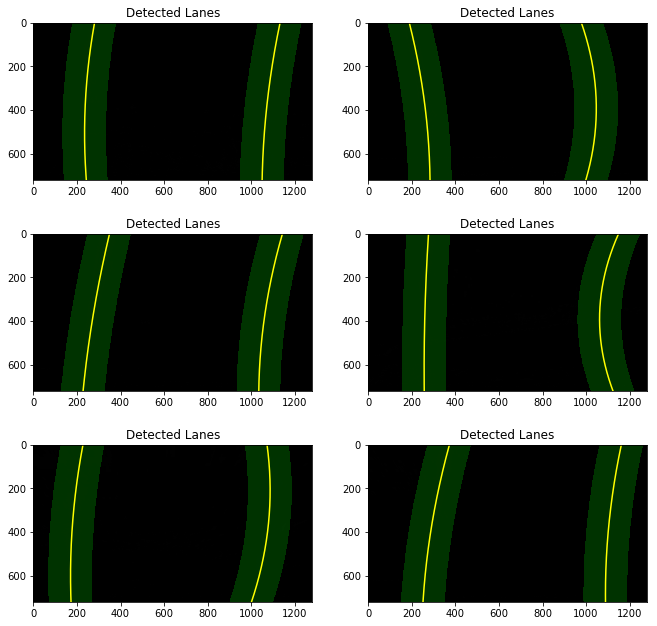

In [32]:
f, ax = plt.subplots(int(len(testimages)/2), int(len(testimages)/3), figsize=(11,11))


        
Display_DetectedLanes(f, ax,testimages,True, margin = 100)

## Radius of Curvature Calculation

In [33]:
# Radius of Curvature Calculation
def radius_curvature_vals(binary_warped, left_fit, right_fit):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    #value in meters
    center = (lane_center - center_image)*xm_per_pix 
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)

    return left_curvature, right_curvature, center

In [34]:
def Visualize_Lanes_on_Image(testimages,visulaize_perstranfrom_flag = True,display_results=True):
    for filename in testimages:
        if(filename=='test_images\\test1.jpg'):
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ret, mtx, dist, rvecs, tvecs = Calc_CamCalibMatrix(nx,ny,img,objpoints,imgpoints)
            Undistorted_Image = Undistort_Images(img,mtx,dist)
            combined_binary_image = combined_s_gradient_thresholds(Undistorted_Image,visulaize_perstranfrom_flag, True)
            warped_img, PerspTrnsfrm_Matrix = Perpective_Transform_Image(combined_binary_image, nx, ny) 
            left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = Detect_lines(warped_img) 
            left_curvature, right_curvature, center = radius_curvature_vals(warped_img, left_fit, right_fit)
        
            ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            # Create an image to draw the lines on
            warp_zero = np.zeros_like(warped_img).astype(np.uint8)
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
            PerspTrnsfrm_Matrix_inv = np.linalg.inv(PerspTrnsfrm_Matrix)
            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, PerspTrnsfrm_Matrix_inv, (img.shape[1], img.shape[0])) 
            # Combine the result with the original image
            result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
            cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
            cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
            cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
            if(display_results == True):
                fig, ax = plt.subplots(figsize=(20, 10))
                ax.imshow(result)
            
        

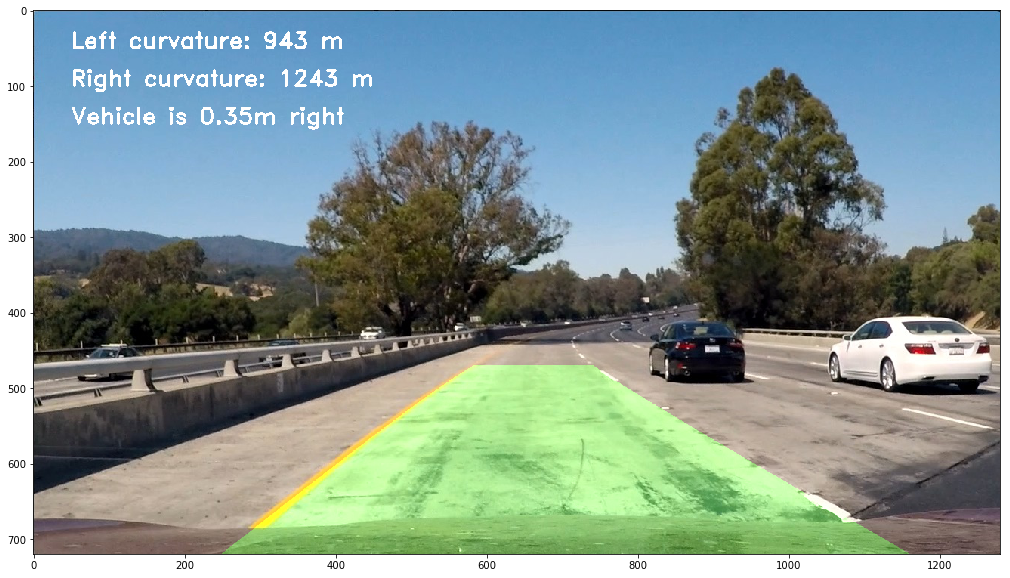

In [35]:
Visualize_Lanes_on_Image(testimages,True,True)

In [36]:
def is_lane_valid(left_fit, right_fit):
    
    #Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: 
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        left = 2*left_fit[0]*360+left_fit[1]
        right = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(left-right)
        
        #Check if lines are parallel at the middle
        if delta_slope_mid <= 0.1:
            status = True
        else:
            status = False
            
    return status

In [37]:
# Lane Class Definition
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0
        
lane = Lane()

In [38]:
def detect_lanes(img):
    ret, mtx, dist, rvecs, tvecs = Calc_CamCalibMatrix(nx,ny,img,objpoints,imgpoints)
    Undistorted_Image = Undistort_Images(img,mtx,dist)
    combined_binary_image = combined_s_gradient_thresholds(Undistorted_Image,True, True)
    warped_img, PerspTrnsfrm_Matrix = Perpective_Transform_Image(combined_binary_image, nx, ny) 
    
    if lane.counter == 0:
        lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = Detect_lines(warped_img)
    else:
        lane.left_fit, lane.right_fit  = Detect_lines_beyond(lane.left_fit, lane.right_fit, warped_img)
    
    # Sanity check
    status = is_lane_valid(lane.left_fit, lane.right_fit)
    
    if status == True:        
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit        
        lane.counter += 1
        lane.reset_counter = 0
    else:   
        # Reset
        if lane.reset_counter > 4:
            lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = Detect_lines(warped_img)
            lane.reset_counter = 0
        else:
            lane.left_fit, lane.right_fit = lane.last_left, lane.last_right
            
        lane.reset_counter += 1
    
    return warped_img, lane.left_fit, lane.right_fit, PerspTrnsfrm_Matrix

In [39]:
def final_pipeline_function(testimages, display_results=False):
    for filename in testimages:
         if(filename=='test_images\\test1.jpg'):
             img = cv2.imread(filename)
             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
             warped_img, left_fit, right_fit, PerspTrnsfrm_Matrix = detect_lanes(img)
             left_curvature, right_curvature, center = radius_curvature_vals(warped_img, left_fit, right_fit)
            
             ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
             left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
             right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

             # Create an image to draw the lines on
             warp_zero = np.zeros_like(warped_img).astype(np.uint8)
             color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

             # Recast the x and y points into usable format for cv2.fillPoly()
             pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
             pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
             pts = np.hstack((pts_left, pts_right))

             # Draw the lane onto the warped blank image
             cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
             PerspTrnsfrm_Matrix_inv = np.linalg.inv(PerspTrnsfrm_Matrix)
             # Warp the blank back to original image space using inverse perspective matrix (Minv)
             newwarp = cv2.warpPerspective(color_warp, PerspTrnsfrm_Matrix_inv, (img.shape[1], img.shape[0])) 
             # Combine the result with the original image
             result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
             cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
             cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
             cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
             if(display_results == True):
                 fig, ax = plt.subplots(figsize=(20, 10))
                 ax.imshow(result)
            
            
    
    

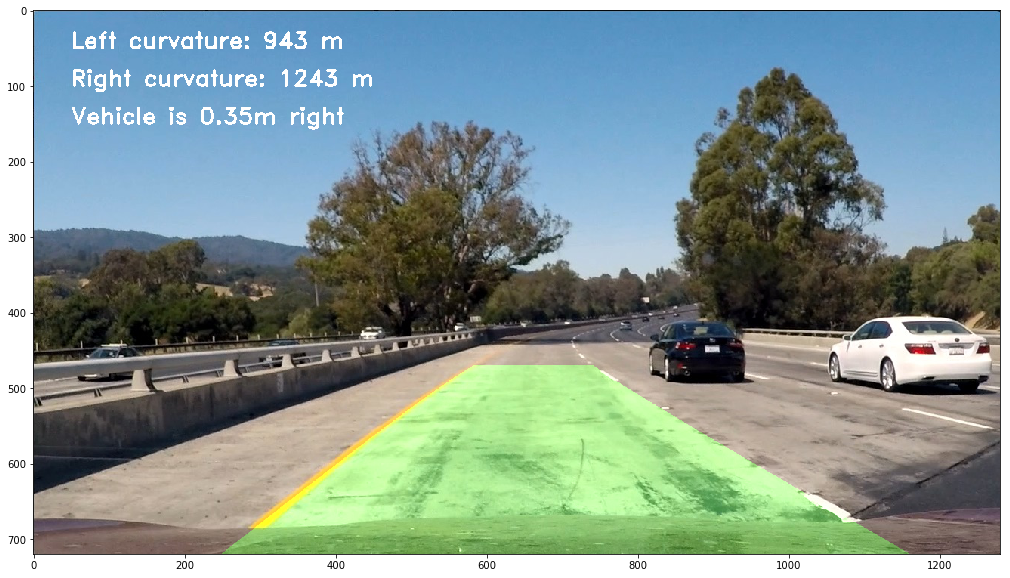

In [40]:
final_pipeline_function(testimages,True)

## Advance Lane Detection on Videos

In [41]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [42]:
def final_pipeline_function_video(frame, display_results=False):
    
    #img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
    warped_img, left_fit, right_fit, PerspTrnsfrm_Matrix = detect_lanes(frame)
    
    
    left_curvature, right_curvature, center = radius_curvature_vals(warped_img, left_fit, right_fit)
            
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
    PerspTrnsfrm_Matrix_inv = np.linalg.inv(PerspTrnsfrm_Matrix)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, PerspTrnsfrm_Matrix_inv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if(display_results == True):
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
        
    return  result 
            

In [43]:
lane = Lane()
def process_image(frame):
    return final_pipeline_function_video(frame,False)

In [37]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:04:58<00:03,  3.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1h 5min 3s


In [38]:
challenge_video_output = 'challenge_video_output.mp4'
clip1_challenge_video = VideoFileClip("challenge_video.mp4")
challenge_video_clip = clip1_challenge_video.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [30:35<00:00,  3.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 30min 41s


In [40]:
harder_challenge_video_output = 'harder_challenge_video_output.mp4'
clip1_harder_challenge_video = VideoFileClip("harder_challenge_video.mp4").subclip(0,15)
harder_challenge_video_clip = clip1_harder_challenge_video.fl_image(process_image)
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



 36%|████████████████████████████▋                                                   | 135/376 [09:56<17:44,  4.42s/it]


 72%|█████████████████████████████████████████████████████████▋                      | 271/376 [21:18<08:15,  4.72s/it]


100%|███████████████████████████████████████████████████████████████████████████████▊| 375/376 [29:08<00:04,  4.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 29min 19s
